In [82]:
import numpy as np
import pandas as pd
from pathlib import Path
from pathlib import Path
import os
from nltk.tokenize import RegexpTokenizer
import nltk
# from sumy.summarizers.lex_rank import LexRankSummarizer 
# #Plain text parsers since we are parsing through text
# from sumy.parsers.plaintext import PlaintextParser
# #for tokenization
# from sumy.nlp.tokenizers import Tokenizer
from nltk.tokenize.toktok import ToktokTokenizer

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint


from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

from functions import *
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_colwidth", 200)
pd.set_option('display.expand_frame_repr', False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
os.chdir('/Users/ariadnavargas/Box Sync/i42 Projects/External Projects/Project ECHO/Phase 3. Execution and dissemination/ProjectECHO/')
textfile = Path("data/raw/Critical Care for the COVID-19 Patient/")
graphs = Path("graphs/")
output = Path("outputs/")
models = Path("models/")
clean = Path("data/clean")
video1 = "2020-07-02 08.01.05 Critical Care for the COVID-19 Patient session 123702861_speaker1.txt"
video2 = "2020-07-02 08.01.05 Critical Care for the COVID-19 Patient session 123702861_speaker2.txt"
videoq = "2020-07-02 08.01.05 Critical Care for the COVID-19 Patient session 123702861_q&a.txt"
graph1 = video1.split('.txt')[0]
graph2 = video2.split('.txt')[0]
graphq = videoq.split('.txt')[0]
topic1_s1= video1.split('.txt')[0]+'_speaker_1.html'
topic1_s2= video1.split('.txt')[0]+'_speaker_2.html'
model1_s1 = video1.split('.txt')[0]+'_speaker1.pkl'
model1_s2 = video1.split('.txt')[0]+'_speaker2.pkl'
data1= video1.split('.txt')[0]+'.csv'
data1_speaker1= video1.split('.txt')[0]+'.txt'
data1_speaker1_section1= video1.split('.txt')[0]+'_section1.txt'
data1_speaker1_section2= video1.split('.txt')[0]+'_section2.txt'
data1_speaker1_section3= video1.split('.txt')[0]+'_section3.txt'
data1_speaker2_section1= video2.split('.txt')[0]+'_section1.txt'
data1_speaker2_section2= video2.split('.txt')[0]+'_section2.txt'
data1_speaker2_section3= video2.split('.txt')[0]+'_section3.txt'

data1_speaker1_section1_key= video1.split('.txt')[0]+'_section1_key.txt'
data1_speaker1_section2_key= video1.split('.txt')[0]+'_section2_key.txt'
data1_speaker1_section3_key= video1.split('.txt')[0]+'_section3_key.txt'
data1_speaker2_section1_key= video2.split('.txt')[0]+'_section1_key.txt'
data1_speaker2_section2_key= video2.split('.txt')[0]+'_section2_key.txt'
data1_speaker2_section3_key= video2.split('.txt')[0]+'_section3_key.txt'

dataq_questions= videoq.split('.txt')[0]+'_questions.txt'
dataq_questions_key= videoq.split('.txt')[0]+'_questions_key.txt'

# Speaker 1

## Import text file

In [84]:
# Read text file into a dataframe
df = pd.read_csv(textfile/video1, sep="\t",
                 header=0,
                 names=["text", "minute"],
                 index_col=False)

In [85]:
df

,text,minute
0,All right.,1.160167
1,"Thanks, Doctor Thornton.",1.166833
2,Good morning and good morning before a holiday weekend.,1.183000
3,"So it's good to see some, uh, fases, even though maybe no one's going anywhere for the holiday.",1.232833
4,"I know I'm not, but that's okay.",1.312833
5,"So thanks for joining us this morning, and I I asked a colleague of mine to give a presentation today on, Ah, diabetes.",1.345167
6,"And the reason, um, you know, the Wuhan data suggested that the patients that had the worst outcome were those with cardiovascular disease and, um, you know, age over, you know, 50 60 70 and I wen...",1.487333
7,"Um, but what we noticed in our cohort of patients, the majority of patients that did poorly were actually diabetics and in potential obese diabetic.",1.758000
8,"So my question was, you know, what is there?",1.923333
9,Is there something specific about diabetes that's putting these patients at risk and do?,1.985833


In [86]:
# Drop empty rows
df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

In [87]:
df.head()

,text,minute
0,All right.,1.160167
1,"Thanks, Doctor Thornton.",1.166833
2,Good morning and good morning before a holiday weekend.,1.183000
3,"So it's good to see some, uh, fases, even though maybe no one's going anywhere for the holiday.",1.232833
4,"I know I'm not, but that's okay.",1.312833


In [88]:
# displaying the number of rows and columns 
rows = df.shape[0] 
cols = df.shape[1] 
print("Rows: " + str(rows)) 
print("Columns: " + str(cols)) 

Rows: 92
Columns: 2


In [89]:
# convert dataframe to list
temp = df.values.tolist()

# for i in temp:
#     print(i[1])

In [90]:
# text=[]
# # remove inner brackets and quotes
# for t in temp:
#     nobrackets = str(t)[1:-1]
#     stripped = nobrackets.strip('"')
#     text.append(str(stripped)[1:-1])

In [91]:
text=[]
time=[]
for i in temp:
    text.append(i[0])
    time.append(i[1])    

In [92]:
# sanity check
for i in range(10):
    print(text[i] + ' Starting time: ' + str(time[i]))

All right. Starting time: 1.1601666666666666
Thanks, Doctor Thornton. Starting time: 1.1668333333333334
Good morning and good morning before a holiday weekend. Starting time: 1.183
So it's good to see some, uh, fases, even though maybe no one's going anywhere for the holiday. Starting time: 1.2328333333333332
I know I'm not, but that's okay. Starting time: 1.3128333333333333
So thanks for joining us this morning, and I I asked a colleague of mine to give a presentation today on, Ah, diabetes. Starting time: 1.3451666666666666
And the reason, um, you know, the Wuhan data suggested that the patients that had the worst outcome were those with cardiovascular disease and, um, you know, age over, you know, 50 60 70 and I went up for decades. Starting time: 1.4873333333333332
Um, but what we noticed in our cohort of patients, the majority of patients that did poorly were actually diabetics and in potential obese diabetic. Starting time: 1.758
So my question was, you know, what is there? Start

In [93]:
section=[]
for i in range(len(text)):
    section.append(0)
len(section)
x=0
for i in range(len(text)):
    if 'family history is positive' not in text[i].lower():
        section[i]=1
        x+=1
    elif 'family history is positive' in text[i].lower():
        section[i]=1
        section[i+1]=2
        x+=1
        print(x)
        break

for i in range(x,len(text)):
    if 'bilateral patch opacities' not in text[i].lower():
        section[i]=2
        x+=1
    elif 'bilateral patch opacities' in text[i].lower():
        section[i]=2
        section[i+1]=3
        x+=1
#         print(text[i])
        break

for i in range(x,len(text)):
#     print(text[i])
    section[i]=3

29


In [94]:
# section

In [95]:
lists = list(zip(section, text, time)) 
df = pd.DataFrame(lists, columns = ['section', 'text', 'time']) 

In [96]:
df

,section,text,time
0,1,All right.,1.160167
1,1,"Thanks, Doctor Thornton.",1.166833
2,1,Good morning and good morning before a holiday weekend.,1.183000
3,1,"So it's good to see some, uh, fases, even though maybe no one's going anywhere for the holiday.",1.232833
4,1,"I know I'm not, but that's okay.",1.312833
5,1,"So thanks for joining us this morning, and I I asked a colleague of mine to give a presentation today on, Ah, diabetes.",1.345167
6,1,"And the reason, um, you know, the Wuhan data suggested that the patients that had the worst outcome were those with cardiovascular disease and, um, you know, age over, you know, 50 60 70 and I wen...",1.487333
7,1,"Um, but what we noticed in our cohort of patients, the majority of patients that did poorly were actually diabetics and in potential obese diabetic.",1.758000
8,1,"So my question was, you know, what is there?",1.923333
9,1,Is there something specific about diabetes that's putting these patients at risk and do?,1.985833


In [97]:
start_time = df.groupby(['section'], sort=False)['time'].max()
start_time.head()
# start_time.to_csv(clean/'speaker1_sections.txt', sep='\t', index=False, header=False)

section
1    3.583333
2    4.544333
3    8.680833
Name: time, dtype: float64

In [99]:
copy = df[['text']].copy()
copy
s1 = df['section']==1
df_1 = df.loc[s1]
df_1 = df_1[['text']]
df_1
df_1.to_csv(clean/'2020-07-02 08.01.05 Critical Care for the COVID-19 Patient session 123702861_speaker1_1.txt', sep='\t', index=False, header=False)

s2 = df['section']==2
df_2 = df.loc[s2]
df_2 = df_2[['text']]
df_2.to_csv(clean/'2020-07-02 08.01.05 Critical Care for the COVID-19 Patient session 123702861_speaker1_2.txt', sep='\t', index=False, header=False)

s3 = df['section']==3
df_3 = df_3.loc[s3]
df_3 = df_3[['text']]
df_3.to_csv(clean/'2020-07-02 08.01.05 Critical Care for the COVID-19 Patient session 123702861_speaker1_3.txt', sep='\t', index=False, header=False)

# Q&A

## Extract questions from chat

In [116]:
# Read text file into a dataframe
df = pd.read_csv('data/raw/Critical Care for the COVID-19 Patient/2020-07-02 08.01.05 Critical Care for the COVID-19 Patient session 123702861_chat.txt', sep="\t",
                 header=0,
                 names=["text"],
                 index_col=False)

In [117]:
df

,text
0,Registration links for all upcoming ECHO Institute New Mexico COVID-19 Sessions:
1,https://echo.unm.edu/covid-19/institute-nm
2,08:10:01
3,08:11:34
4,"COVID-19 in People With Diabetes: Urgently Needed Lessons From Early Reports (Riddle, et.al.):"
5,https://doi.org/10.2337/dci20-0024
6,08:12:53
7,"Covid-19 in Critically Ill Patients in the Seattle Region — Case Series (Bhatraju, et.al.):"
8,https://doi.org/10.1056/NEJMoa2004500
9,08:13:53


In [118]:
chat = df['text'].tolist()

In [113]:
questions=[]
import re 
  
# initializing list  
test_list = ['? ', '?\n'] 
  
for i in text:
    print(i)
    res = [ele for ele in test_list if(ele in i)]
    if bool(res)== True:
#             print(i)
            questions.append(i)

That's a great question.
Um, and I'll let Matt add here too, because I was wondering because I've seen a few that have just had, um, obesity.
We have, Ah, a 33 year old, uh, obese gentlemen, 56 BMI.
On ECMO
Who didn't have diabetes, And we haven't had a 23 year old admitted that didn't have diabetes.
He was just a little portly.
Not much, but he you know, 23.
So I think the diabetes, um, is a risk factor for some, but I think obesity really adds into that.
I don't know Matt if you have any other, uh, comments on that.
Yeah, I agree with you, Michelle.
There There is a great question, too.
Um, there's definitely something there.
There's a signal that people with obesity independent of diabetes are also at increased risk.
Um, how much of that is from the in people with diabetes The worst outcomes.
How much of that is from obesity versus the diabetes?
I don't I haven't seen any reports that are able to parse that out as a whole.
Those with Type one diabetes are leaner than those with Type

In [112]:
len(questions)

0

In [131]:
questions_clean=[]
for q in questions:
    clean=q.split(':')
#     print(clean[3])
    questions_clean.append(clean[3])

In [132]:
# for q in questions_clean:
#     print(q)
len(questions_clean)

13

In [133]:
# f=open(clean/dataq_questions,'w') 
f=open('data/clean/2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_chat_questions.txt','w')
i=0
for q in questions_clean:
    i+=1
    f.write(str(i)+'. '+q+'\n')

f.close()

In [134]:
questions_clean

[' In those with prolonged symptoms, does that correlate with prolonged viral shedding and infectivity?\n',
 ' Are patients reporting their Covid-19 tests are not being covered by Premera or BC/BS insurance vs Medicare if for travel and they have not had exposures or symptoms?\n',
 ' did the increase in CV-19 relate to the increase in testing?\n',
 ' If Covid19 is airborne, then we have to improve the ventilation in many/most places to created negative pressure. How is this being addressed?\n',
 ' Based on what we know today, how relevant is to take the temperature of patients to enter a clinic?\n',
 ' CDC says children less than 2 should not wear a mask; some pediatricians are advising children less than 5 should not wear a mask. How do we advise our clients?\n',
 ' In relation to airborne issues, does UV light work?\n',
 ' Should we be using more N-95 type masks and less surgical masks in the healthcare settings?\n',
 ' Does the hospital have enough N-95?s for staff?\n',
 ' COVID19 i

## Normalize and clean-up

### Build normalizer

In [135]:
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata
from bs4 import BeautifulSoup

nlp = spacy.load('en', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# stopword_list.remove('no')
# stopword_list.remove('not')

# 1. Remove html tags
def strip_html_tags(text):
    soup=BeautifulSoup(text,"html.parser")
    stripped_text=soup.get_text()
    return stripped_text
strip_html_tags('<html><h2>Some important text</h2></html>')

# 2. Remove accents
def remove_accented_chars(text):    
    text=unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
remove_accented_chars('Sómê Áccèntéd téxt')

# 3. Expand contractions
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
expand_contractions("Y'all can't expand contractions I'd think")

# 4. Remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, ' ', text)
    return text
remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

# 5. Lemmatization
def lemmatize_text(text):
    text=nlp(text)
    text=' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
lemmatize_text('My system keeps crashing! his crashed yesterday, ours crashes daily')

# 6. Stemming
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

# 7. Remove stopwords
def remove_stopwords(text, is_lowercase=False):
    tokens=tokenizer.tokenize(text)
    tokens=[token.strip() for token in tokens]
    if is_lowercase:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens=[token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
remove_stopwords("The, and, if are stopwords, computer is not")


', , stopwords , computer'

In [136]:
# Turn on functions as desired
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    # Run normalizer on corpus
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [137]:
clean_text = normalize_corpus(questions_clean)
clean_text 

['prolonged symptom correlate prolong viral shedding infectivity',
 'patient report covid test cover premera bc bs insurance vs medicare travel exposure symptom',
 'increase cv relate increase testing',
 'covid airborne improve ventilation many place create negative pressure address',
 'base know today relevant take temperature patient enter clinic',
 'cdc say child less wear mask pediatrician advise child less wear mask advise client',
 'relation airborne issue uv light work',
 'use n type mask less surgical mask healthcare setting',
 'hospital enough n staff',
 'covid transmit via fomite droplet airborne know number one way people get',
 'recommend continue take temperature patient come clinic risk factor continue recommend method screen covid',
 'go less likely develop antibody get monoclonal antibody',
 'really important question leslie test isolate per cdc clear really complicate decision tree get second positive test person still shed infectious virus even know work short viral c

### Tokenize

In [138]:
from spacy.tokenizer import Tokenizer
tokens = []
tokenizer = Tokenizer(nlp.vocab)


for doc in tokenizer.pipe(df['text_clean'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
#         print(token)
        doc_tokens.append(token)
    tokens.append(doc_tokens)
# Makes tokens column
df['tokens']=tokens

df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

In [139]:
df.head(50)

,section,text,time,text_clean,tokens,tokens_back_to_text
0,0,It's from JAMA.,15.642833,jama,[jama],jama
1,1,And it was on the science of persuasion.,15.660000,science persuasion,"[science, persuasion]",science persuasion
2,1,"How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention.",15.694000,um guess actually lot study persuade people thing um opportune lesson covid prevention,"[um, guess, actually, lot, study, persuade, people, thing, um, opportune, lesson, covid, prevention]",um guess actually lot study persuade people thing um opportune lesson covid prevention
3,1,"So they talked about the five habit promoting strategies which, um, if you want somebody to develop a habit, get exercising or, um, eating more vegetables or wearing a mask.",15.835667,talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask,"[talk, five, habit, promote, strategy, um, want, somebody, develop, habit, get, exercise, um, eat, vegetable, wear, mask]",talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask
4,1,They said there's five things to do.,16.033667,say five thing,"[say, five, thing]",say five thing
5,1,You want to make it easy to start and easy to repeat.,16.054500,want make easy start easy repeat,"[want, make, easy, start, easy, repeat]",want make easy start easy repeat
6,1,"You wanna make it rewarding to repeat, you want to tie the behavior to an existing habit.",16.108167,wanna make rewarding repeat want tie behavior existing habit,"[wanna, make, rewarding, repeat, want, tie, behavior, existing, habit]",wanna make rewarding repeat want tie behavior existing habit
7,1,"And I know I do this with people all the time suggesting they take pills when they first like that, and talk about behaviors that conflict with existing habits and provide alternative behaviors an...",16.178833,know people time suggest take pill first like talk behavior conflict existing habit provide alternative behavior provide specific description desire behavior discuss um first one make behavior eas...,"[know, people, time, suggest, take, pill, first, like, talk, behavior, conflict, existing, habit, provide, alternative, behavior, provide, specific, description, desire, behavior, discuss, um, fir...",know people time suggest take pill first like talk behavior conflict existing habit provide alternative behavior provide specific description desire behavior discuss um first one make behavior eas...
8,1,"Repeat, making handwashing stations and hand sanitizer available everywhere really makes a difference on how often people wash their hands, and you know it's obvious.",16.488167,repeat make handwashing station hand sanitizer available everywhere really make difference often people wash hand know obvious,"[repeat, make, handwashing, station, hand, sanitizer, available, everywhere, really, make, difference, often, people, wash, hand, know, obvious]",repeat make handwashing station hand sanitizer available everywhere really make difference often people wash hand know obvious
9,1,"But, um, often we don't have hand sanitizer readily available, so making it readily available.",16.633833,um often hand sanitizer readily available make readily available,"[um, often, hand, sanitizer, readily, available, make, readily, available]",um often hand sanitizer readily available make readily available


In [140]:
df.head()

,section,text,time,text_clean,tokens,tokens_back_to_text
0,0,It's from JAMA.,15.642833,jama,[jama],jama
1,1,And it was on the science of persuasion.,15.660000,science persuasion,"[science, persuasion]",science persuasion
2,1,"How you can, um I guess there's actually been a lot of studies on How do you persuade people to do things and, um, opportune lessons for COVID-19 prevention.",15.694000,um guess actually lot study persuade people thing um opportune lesson covid prevention,"[um, guess, actually, lot, study, persuade, people, thing, um, opportune, lesson, covid, prevention]",um guess actually lot study persuade people thing um opportune lesson covid prevention
3,1,"So they talked about the five habit promoting strategies which, um, if you want somebody to develop a habit, get exercising or, um, eating more vegetables or wearing a mask.",15.835667,talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask,"[talk, five, habit, promote, strategy, um, want, somebody, develop, habit, get, exercise, um, eat, vegetable, wear, mask]",talk five habit promote strategy um want somebody develop habit get exercise um eat vegetable wear mask
4,1,They said there's five things to do.,16.033667,say five thing,"[say, five, thing]",say five thing


## Text mining

In [141]:
def get_trigrams(trigrams, top_grams):    
    grams_str = []
    data = []
    gram_counter = Counter(trigrams)
    for grams in gram_counter.most_common(20):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,3):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)
    df = pd.DataFrame(data, columns = ['Grams', 'Count'])
    return df

def get_bigrams(bigrams, top_grams):    
    grams_str = []
    data = []

    gram_counter = Counter(bigrams)
    
    for grams in gram_counter.most_common(20):
        gram = ''
        grams_str = grams[0]
        grams_str_count = []
        for n in range(0,2):
            gram = gram + grams_str[n] + ' '
        grams_str_count.append(gram)
        grams_str_count.append(grams[1])
        data.append(grams_str_count)
        print(grams_str_count)
    df = pd.DataFrame(data, columns = ['Grams', 'Count'])
    return df


import seaborn as sns
def plot_frequency_chart(info):
#     sns.set_style("white")
    sns.set_style("ticks")
    sns.set_context("poster")
    sns.plotting_context()
    fig, ax = plt.subplots(figsize=(18, 8))
#     plt.style.use('seaborn-whitegrid')
    sns.set_context("notebook", font_scale=1)    
    ax = sns.barplot(x=info['x'], y=info['y'], data=info['data']
                     , color=(info['pal'])
                    )
    ax.yaxis.get_major_locator().set_params(integer=True)
    ax.set_title(label=info['title'], fontweight='bold', size=22)
    plt.ylabel(info['ylab'], fontsize=20)
    plt.xlabel(info['xlab'], fontsize=20)
    plt.xticks(rotation=info['angle'],fontsize=18)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(graphs/info['fname'])
    return

nlp = spacy.load('en_core_web_lg')
# Tokenizer
# tokenizer = Tokenizer(nlp.vocab)


In [142]:
big_string= ' '.join([text for text in clean_text])

exceptions_list = [ 'go ', 'pretty ', 'mostly', 'lot ', 'thing ', 
                   'cover ', 'know ', 'see ', 'also ', 'um ', 'think '] # pull out these words from the corpus
for word in exceptions_list:
    big_string=big_string.replace(word,'')

big_string=remove_special_characters(big_string, 
                          remove_digits=False)
    
words = big_string.split()
len(words) 

135

['take temperature patient ', 2]
['child less wear ', 2]
['less wear mask ', 2]
['prolonged symptom correlate ', 1]
['symptom correlate prolong ', 1]
['correlate prolong viral ', 1]
['prolong viral shedding ', 1]
['viral shedding infectivity ', 1]
['shedding infectivity patient ', 1]
['infectivity patient report ', 1]
['patient report covid ', 1]
['report covid test ', 1]
['covid test premera ', 1]
['test premera bc ', 1]
['premera bc bs ', 1]
['bc bs insurance ', 1]
['bs insurance vs ', 1]
['insurance vs medicare ', 1]
['vs medicare travel ', 1]
['medicare travel exposure ', 1]


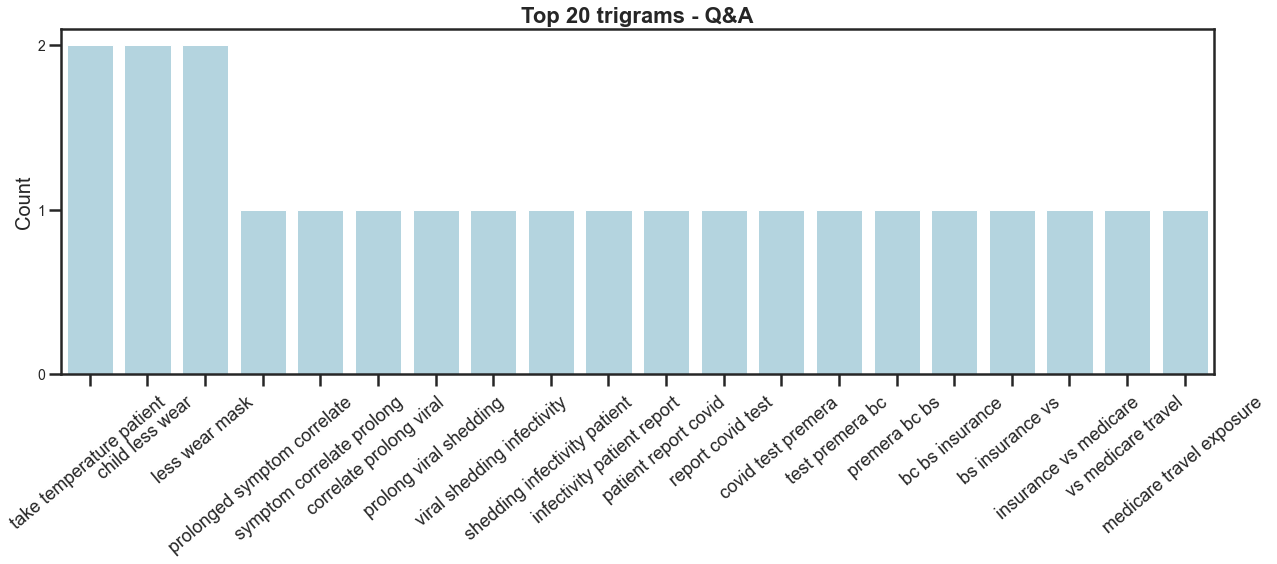

In [143]:
from collections import Counter
import matplotlib.pyplot as plt 

trigrams = nltk.trigrams(words)

df_trigrams = get_trigrams(trigrams, 10)

top25_tri = df_trigrams.iloc[:10,:]
info = {'data': df_trigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count',  'pal':'lightblue',
       'title': 'Top 20 trigrams - Q&A',
       'fname': graphq+'_trigrams.png',
       'angle': 40}
plot_frequency_chart(info)

In [144]:
top_tri = df_trigrams.iloc[:4,:]
# top_tri
top_grams=list(top_tri['Grams'])
top_grams

['take temperature patient ',
 'child less wear ',
 'less wear mask ',
 'prolonged symptom correlate ']

['take temperature ', 2]
['temperature patient ', 2]
['child less ', 2]
['less wear ', 2]
['wear mask ', 2]
['prolonged symptom ', 1]
['symptom correlate ', 1]
['correlate prolong ', 1]
['prolong viral ', 1]
['viral shedding ', 1]
['shedding infectivity ', 1]
['infectivity patient ', 1]
['patient report ', 1]
['report covid ', 1]
['covid test ', 1]
['test premera ', 1]
['premera bc ', 1]
['bc bs ', 1]
['bs insurance ', 1]
['insurance vs ', 1]


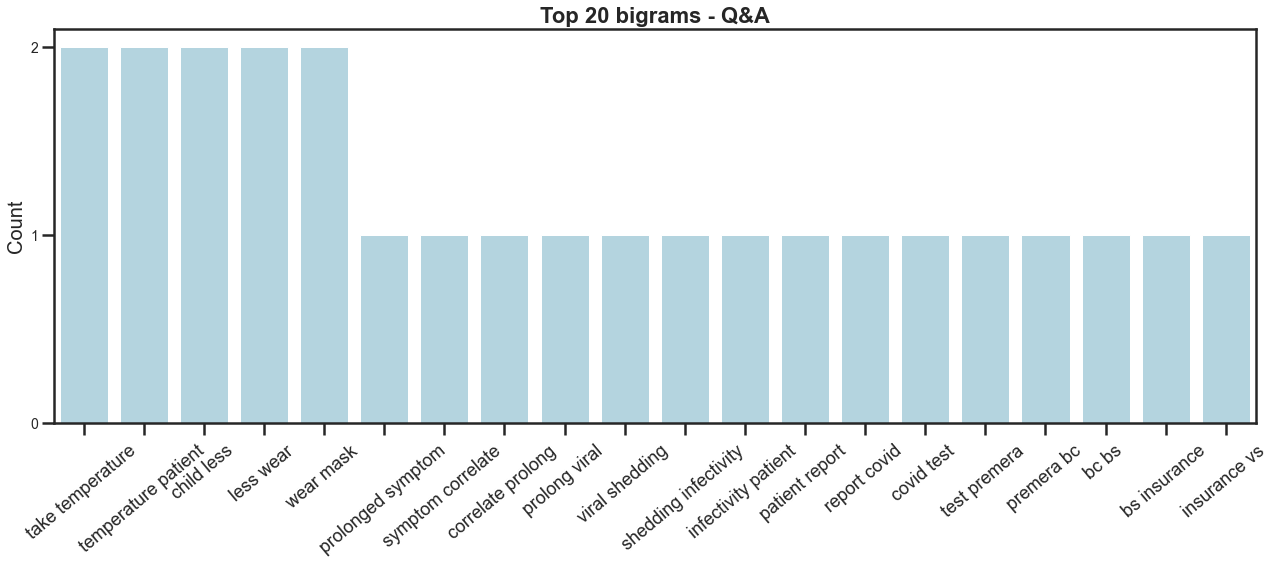

In [145]:
# import matplotlib.style as style
# style.available
# style.use('Solarize_Light2')

bigrams = nltk.bigrams(words)

df_bigrams = get_bigrams(bigrams, 10)
df_bigrams
top_tri = df_bigrams.iloc[:10,:]
info = {'data': df_bigrams, 'x': 'Grams', 'y': 'Count',
       'xlab': '', 'ylab': 'Count', 'pal':'lightblue',
       'title': 'Top 20 bigrams - Q&A',
       'fname': graphq+'_bigrams.png',
       'angle': 40}
plot_frequency_chart(info)

In [146]:
top_grams=[]
top_bi = df_bigrams.iloc[:12,:]
# top_tri
top_bi_list=(list(top_bi['Grams']))
for i in top_bi_list:
    top_grams.append(i)
top_grams 

['take temperature ',
 'temperature patient ',
 'child less ',
 'less wear ',
 'wear mask ',
 'prolonged symptom ',
 'symptom correlate ',
 'correlate prolong ',
 'prolong viral ',
 'viral shedding ',
 'shedding infectivity ',
 'infectivity patient ']

In [147]:
unigrams = Counter(words).most_common(15)
for i in range(6):
    top_grams.append(unigrams[i][0])


In [148]:
unigrams

[('covid', 4),
 ('less', 4),
 ('mask', 4),
 ('patient', 3),
 ('test', 3),
 ('airborne', 3),
 ('get', 3),
 ('symptom', 2),
 ('viral', 2),
 ('increase', 2),
 ('take', 2),
 ('temperature', 2),
 ('clinic', 2),
 ('cdc', 2),
 ('child', 2)]

In [149]:
top_grams

['take temperature ',
 'temperature patient ',
 'child less ',
 'less wear ',
 'wear mask ',
 'prolonged symptom ',
 'symptom correlate ',
 'correlate prolong ',
 'prolong viral ',
 'viral shedding ',
 'shedding infectivity ',
 'infectivity patient ',
 'covid',
 'less',
 'mask',
 'patient',
 'test',
 'airborne']

In [150]:
# f=open(data/clean/dataq_questions_key,'w') 
f=open('data/clean/2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_chat_questions_key.txt' ,'w')
for ele in top_grams:
    f.write('#'+ele+' ')

f.close()

# Literature

In [151]:
import re

blogs=[]
for t in text_list:
    res=re.findall(r'(https?://\S+)', t)
    if bool(res)==True:
        if 'unm.edu' not in res[0]:
            if 'covid19_office_hours' not in res[0]:
                if 'youtube.com' not in res[0]:
                    if 'doi' not in res[0]:
                        print(res[0])
                        blogs.append(res[0])
                
        
len(blogs)

https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/how-covid-spreads.html
https://www.scientificamerican.com/article/covid-19-is-now-the-third-leading-cause-of-death-in-the-u-s1/
https://uhfnyc.org/publications/publication/covid-19-ripple-effect-impact-covid-19-children-new-york-state/
https://webnew.ped.state.nm.us/wp-content/uploads/2020/09/NMPED_COVID19ResponseToolkit_ELEMpublic.pdf
https://services.aap.org/en/pages/2019-novel-coronavirus-covid-19-infections/clinical-guidance/covid-19-testing-guidance/
https://medium.com/@robinschoenthaler/covid-myth-busting-b5b26b22970f
https://www.theatlantic.com/ideas/archive/2020/10/schools-arent-superspreaders/616669/
https://www.politico.com/news/magazine/2020/09/25/how-covid-19-pandemic-ends-421122
https://www.epa.gov/coronavirus/air-cleaners-hvac-filters-and-coronavirus-covid-19
http://blog.jetblue.com/category/archives/coronavirus/
https://www.fda.gov/medical-devices/coronavirus-covid-19-and-medical-devices/uv-lights-and-lamps-u

12

In [152]:
articles=[]
for t in text_list:
    res=re.findall(r'(https?://\S+)', t)
    if bool(res)==True:
        if 'unm.edu' not in res[0]:
            if 'covid19_office_hours' not in res[0]:
                if 'youtube.com' not in res[0]:
                    if 'doi' in res[0]:
                        print(res[0])
                        articles.append(res[0])
                
        
len(articles)

https://doi.org/10.1056/NEJMoa2028436
https://doi.org/10.1001/jamainternmed.2020.6319
https://doi.org/10.1016/j.cmi.2020.09.052
https://doi.org/10.1056/NEJMoa2007764
http://dx.doi.org/10.15585/mmwr.mm6940e3
https://doi.org/10.1001/jama.2020.15139
https://doi.org/10.1186/s12985-020-01418-7


7

## Summary of blog posts

In [153]:
import pandas as pd
import newspaper
from newspaper import Article
from newspaper import fulltext
import requests
from gensim.summarization import summarize
from gensim.summarization import keywords
from docx import Document
from docx.text.paragraph import Paragraph

In [154]:
import docx

doc = docx.Document()
doc.save('data/clean/2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_blogs.docx')

for link in blogs:
    try:
        # Pass link into article 
        article = Article(link)

        # Call the download and parse methods to download information 
        article.download()
        article.parse()
        html = requests.get(link).text

        # Grab article's body
        body = fulltext(html)

        # Grab article's info
        title=article.title
        date = article.publish_date

        # Run nlp method to extract the keywords and summary of the article
        article.nlp()

        # Split into sentences and remove empty spaces
        text=(body)
        sentences=text.split('\n')
        while('' in sentences) : 
            sentences.remove('') 

        # Create a single string
        article_string = ' '.join(sentences)

        # Summarize with Gensim
        if len(article_string)<4000:
            summary = summarize(article_string, word_count=200) # use wordcount if article is too short
        else:
            summary = summarize(article_string, ratio=0.10) # otherwise the output will include 5% of the total number of words
        summary_length = summary.split('.')

        # Get keywords
        key= keywords(article_string, lemmatize=True, words=10).split('\n')

        # Print to Word
        doc = Document('data/clean/2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_blogs.docx')
        doc.add_heading(f'{title}', 1)
    #     doc.add_heading(f'Date: {date.month}/{date.day}/{date.year}', 6)
        paraKey = doc.add_heading('Keywords: ', 7)
        i=0
        while i<6:
            paraKey.add_run(key[i] + ', ') 
            i+=1
        paraKey.add_run(key[6] + '.')
        doc.add_heading(f'Source: {link}', 6)
    #     doc.add_heading(f'Length of original article: {len(sentences)} ; length of summary: {len(summary_length)}', 6)
        doc.add_heading(f'Summary:',6)
        doc.add_paragraph(summary)
        doc.add_page_break() 
        doc.save('data/clean/2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_blogs.docx')
    except Exception as e:
        print(e)
        


Article `download()` failed with HTTPSConnectionPool(host='webnew.ped.state.nm.us', port=443): Max retries exceeded with url: /wp-content/uploads/2020/09/NMPED_COVID19ResponseToolkit_ELEMpublic.pdf (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fbcc7e1c150>, 'Connection to webnew.ped.state.nm.us timed out. (connect timeout=7)')) on URL https://webnew.ped.state.nm.us/wp-content/uploads/2020/09/NMPED_COVID19ResponseToolkit_ELEMpublic.pdf


In [155]:
# from docx2pdf import convert
# convert("data/clean/2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_blogs.docx", 
#         "data/clean/2020-10-12 12.03.10 Office Hours NM COVID-19 659261463_blogs.pdf")

# Speaker 2

In [ ]:
'Is diabetes a risk factor for COVID-19: series of studies'
'how can we quantify the increased risk'
'how does glycemia control impact'
'Why do people outside of hyperglycemia'
'Conclusions'
